# Vehicle Detection Tutorial

### Support Vector Machine vs YOLO V2

This notebook would walk you through how to build a Support Vector Machine Classifier to detect vehicles. At the same time, we also compare the SVM classifier's performance to the YOLO V2.

With applying two tweaks during training and detection, the SVM Classifier (99.26%) works better in term of detection and run-time performance.

In [1]:
# Util libraries
import cv2
import os, fnmatch
import numpy as np
import time
import itertools

# Helper functions
from utils import get_file_names
from utils import get_feature, extract_feature
from sklearn.preprocessing import StandardScaler

#  SVC and YOLO classifier
from utils import SupportVectorMachineClassifier, YOLOV2

# Visualiztion
import matplotlib.pyplot as plt
%matplotlib inline

## Import Dataset

In [2]:
# Import car and not car images
cars = get_file_names('./data/vehicles', pattern='*.png')
not_cars = get_file_names('./data/non-vehicles', pattern='*.png')
print("Car Images :{} images\nNot Car Images: {} images".format(len(cars),len(not_cars)))

Car Images :8792 images
Not Car Images: 8968 images


## Data Exploration

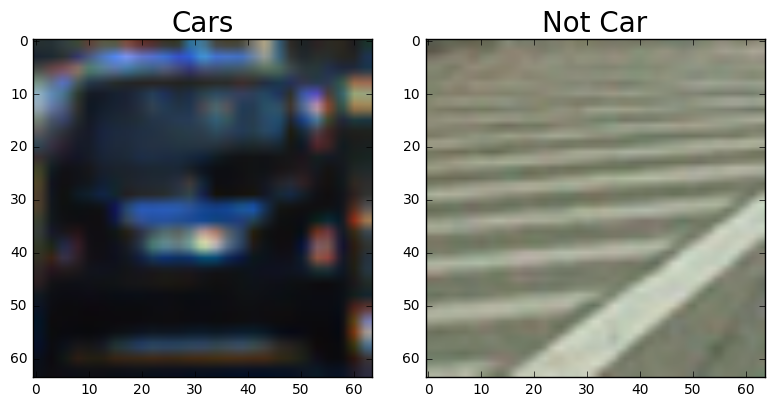

In [5]:
# Data Exploration
idx = np.random.randint(0, len(cars))
imgs = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in (cars[idx], not_cars[idx])]
a, fg = plt.subplots(1,2, figsize=(8, 5))
a.tight_layout()
fg[0].imshow(imgs[0])
fg[0].set_title("Cars", fontsize=20)
fg[1].imshow(imgs[1])
fg[1].set_title("Not Car", fontsize=20)

### Tweak 1: Adaptive Histogram Equalization before extracting feature.

We discovered that the training data is somewhat blurry and noisy. In this project, we combine the Feature vector of each image so it is important to have a clear image for training. In Deep Learning approach, however, it might help the model generalize better.

By applying `Adaptive Histogram Equalization` (AHE), we could achieve better image quality. **The tradeoff is speed. However, we only apply AHE during training.**

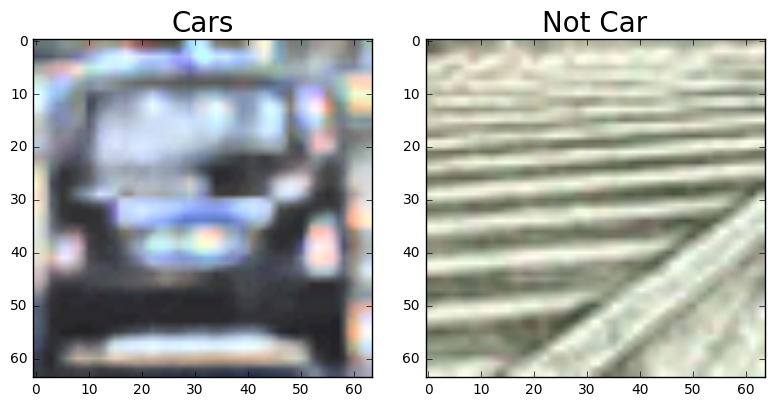

In [6]:
def adaptive_equalize_image(gray_img, level):
    """
    Equalize an image - Increase contrast for the image
    # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    """
    clahe = cv2.createCLAHE(clipLimit=level, tileGridSize=(8, 8))
    if gray_img.shape[2] == 3:
        lab = cv2.cvtColor(gray_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        cl = clahe.apply(l)
        result = cv2.merge((cl, a, b))
        result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
        
    else:
        result = clahe.apply(img)
    return result

eql_imgs = [adaptive_equalize_image(img, 3.0) for img in imgs]

a, fg = plt.subplots(1,2, figsize=(8, 5))
a.tight_layout()
fg[0].imshow(eql_imgs[0])
fg[0].set_title("Cars", fontsize=20)
fg[1].imshow(eql_imgs[1])
fg[1].set_title("Not Car", fontsize=20)


### Features in an Image - Histogram of Gradient, Color Histogram, Spatial Binary

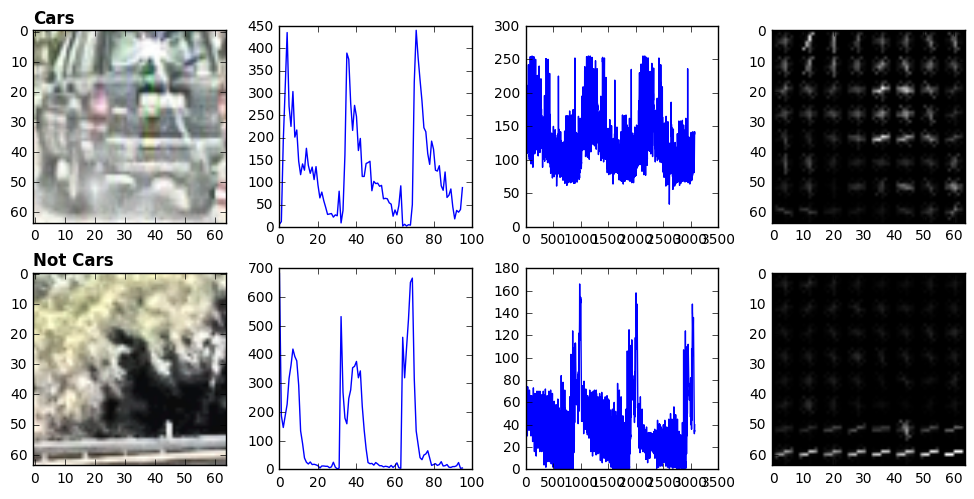

In [7]:
from utils import get_hog_features, color_hist, bin_spatial
idx = np.random.randint(0, len(cars))
imgs = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in (cars[idx], not_cars[idx])]
a, fg = plt.subplots(2,4, figsize=(10, 5))
a.tight_layout()
txt = ("Cars", "Not Cars")
for idx, img in enumerate(imgs):
    color = color_hist(img)
    _, hog = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    spatial_bin = bin_spatial(img)
    fg[idx, 0].set_title(txt[idx],loc='left', fontweight='bold')
    fg[idx, 0].imshow(adaptive_equalize_image(img, 3.0))
    fg[idx, 1].plot(color)
    fg[idx, 2].plot(spatial_bin)
    fg[idx, 3].imshow(hog, cmap='gray')

## Extract Combined Feature Vector for Car and Not-Car Images



### Pre-propcessing:
`adaptive_histogram_equalization`: **True**

### HOG Parameters

| Parameters      | Value |
|: -------------- |------:| 
| `orientation`   | 9     |
| `pix_per_cell`  | 8     | 
| `cell_per_block`| 2     | 
| `hog_channel`   | `'ALL`|
| `transform_srt` | False |
| `feature_vector`| True  |


### Color Histogram Parameters:

| Parameters   | Value     |
|: ----------- |----------:| 
| `nbins`      | 32        |
| `bin_range`  | (0.0, 1.0)| 


### Spatial Bin Parameters:
| Parameters   | Value   |
|: ----------- |--------:| 
| `color_space`| `YCrCb` |
| `spatial_bin`| (32, 32)| 



In [8]:
# Calculate car features & not-car features
t = time.time()
# Workers for parallel multi processing, please change based on your CPU.
# The Adaptive Histogram Equalization will significantly increase the processing time.

print("Calculating Car Feature Vector on {} images".format(len(cars)))
car_features = get_feature(cars, workers=4)
print("Calculating Not-Car Feature Vector on {} images".format(len(not_cars)))
not_car_features = get_feature(not_cars, workers=4)
print("Completed calculating feature in {:f} seconds\n".format((time.time() - t), 3))

Calculating Car Feature Vector on 8792 images
Total time: 27.027137756347656 seconds
Average time / feature : 0.007813306913471308 seconds
Max Value 0.8392156862745098 Min Value 0.058823529411764705

Calculating Not-Car Feature Vector on 8968 images
Total time: 23.452863454818726 seconds
Average time / feature : 0.007057580163072625 seconds
Max Value 1.0 Min Value 0.23529411764705882

Completed calculating feature in 50.566997 seconds



Feature length:  8460


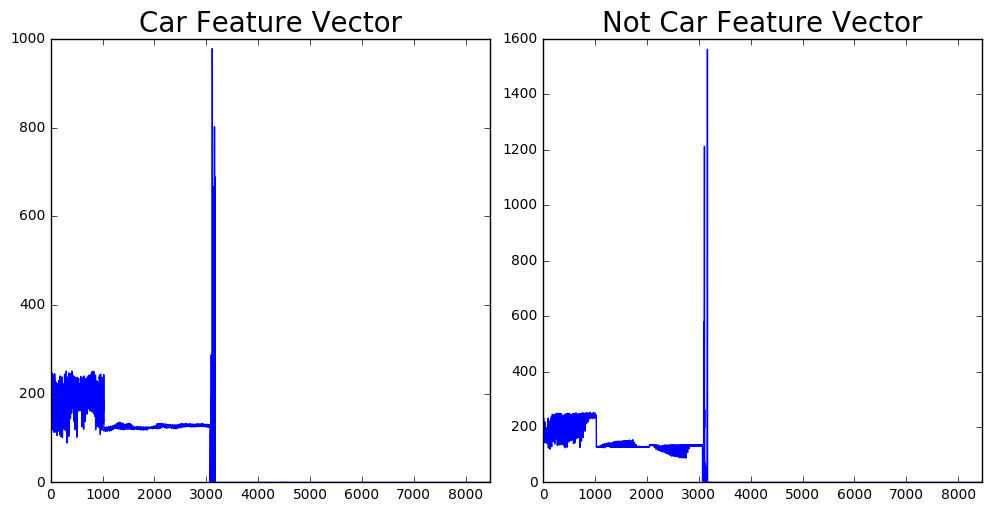

In [9]:
idx = np.random.randint(0, len(cars))
print("Feature length: ", len(car_features[idx]))
saved_unormalized = car_features[idx] # To compare between unormalized and normalized
a, fg = plt.subplots(1,2, figsize=(10, 5))
a.tight_layout()
fg[0].plot(car_features[idx])
fg[0].set_xlim([0,len(car_features[idx])])
fg[0].set_title("Car Feature Vector", fontsize=20)

fg[1].plot(not_car_features[idx])
fg[1].set_xlim([0,len(car_features[idx])])
fg[1].set_title("Not Car Feature Vector", fontsize=20)

## Normalize feature vector using StandardScaler()

In [10]:
from sklearn.model_selection import train_test_split
# Create data set
x = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.concatenate((np.ones(len(car_features)), np.zeros(len(not_car_features))))
print("Training feature vector's size", x.shape)
# Apply Standard Scalars to normalize vector 
X_scaler = StandardScaler().fit(x)
scaled_x = X_scaler.transform(x)

random_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=random_state)
print("Training data: Features {}, Labels {}".format(len(x_train), len(y_train)))
print("Test data: Features {}, Labels {}".format(len(x_test), len(y_test)))

Training feature vector's size (17760, 8460)
Training data: Features 14208, Labels 14208
Test data: Features 3552, Labels 3552


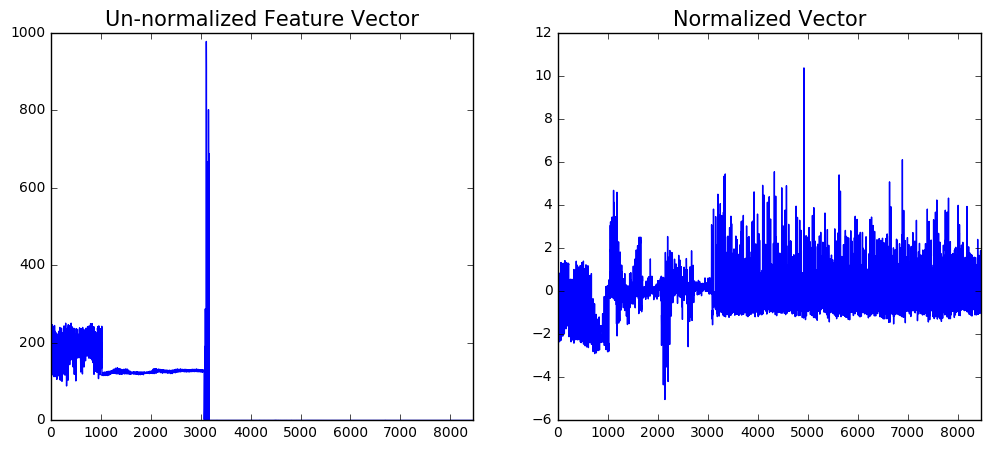

In [11]:
idx = np.random.randint(0, len(cars))
a, fg = plt.subplots(1,2, figsize=(12, 5))
fg[0].plot(saved_unormalized)
fg[0].set_xlim([0,len(x[idx])])
fg[0].set_title("Un-normalized Feature Vector", fontsize=15)
fg[1].plot(scaled_x[idx])
fg[1].set_xlim([0,len(x[idx])])
fg[1].set_title("Normalized Vector", fontsize=15)

## Build SVC Classifier and YOLO-V2 Classifier

In [12]:
# Build YOLO-V2 Classifier - I am using pre-trained model  on darkflow
yolo = YOLOV2(cfg_path="cfg/tiny-yolo-voc.cfg", weight_path="bin/tiny-yolo-voc.weights")
# yolo = YOLOV2(cfg_path="cfg/yolo-voc.cfg", weight_path="bin/yolo-voc.weights")

Parsing ./cfg/tiny-yolo-voc.cfg
Parsing cfg/tiny-yolo-voc.cfg
Loading bin/tiny-yolo-voc.weights ...
Successfully identified 63471556 bytes
Finished in 0.0068700313568115234s


In [13]:
# svc = Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge')),])
svc = SupportVectorMachineClassifier()
# Apply Standard Scalars to normalize vector
svc.train(x_train, y_train)
# Test on testing set
score = svc.score(x_test, y_test)



Starting to train vehicle detection classifier.
Completed training in 41.453480 seconds.

Testing accuracy:
Accuracy 0.991836%


## Detection Pipeline:
There will be two parts:

* Using sliding technique: slow and provide a lot of False Positives
* Using subsampling HOG and adding heatmap threshold: faster and eliminate a lot of False Positives

### Sliding Window and Search Window to detect cars in image for SVC

In [14]:
# Create a list of windows for SVC to select a region of image and compare with the feature vector
def slide_window(img_size, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Returns all windows to search in an image.
    No classification has been done at this stage.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_size[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] =  img_size[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, boxes, color=(0, 0, 255), thickness=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thickness)
    return draw_img

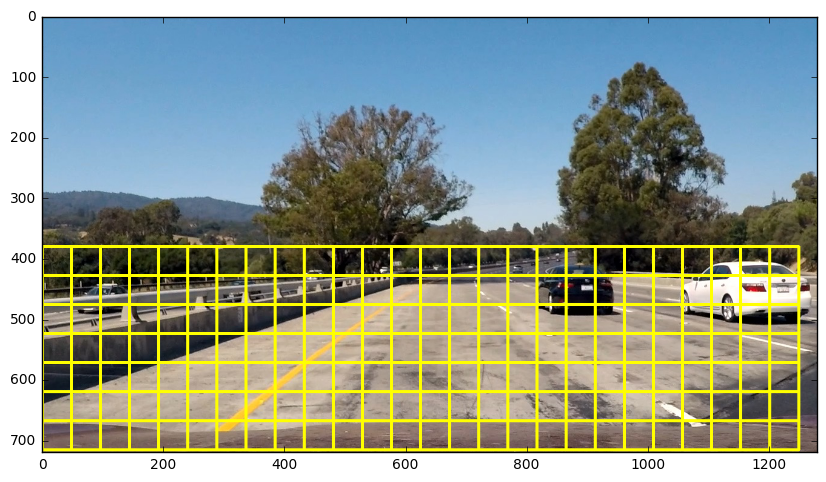

In [15]:
import itertools

test_img = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
img_size = test_img.shape[:2]
windows = slide_window(img_size, x_start_stop=[None, None], y_start_stop=[380, 720],
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))


draw_img = draw_boxes(test_img, windows, color=(255, 255, 0), thickness=4)
a = plt.figure( figsize =(10, 20))
plt.imshow(draw_img)


In [16]:
def search_windows(frame, windows, clf, size=(64, 64), decision_threshold=0.3):
    on_windows = []
    for window in windows:
        # Get a region of an image
        region = cv2.resize(frame[window[0][1]:window[1][1], window[0][0]:window[1][0]], size)
        
        # Extract feature of mini image
        region_feature = np.concatenate(extract_feature(region))
        region_feature = region_feature.astype(np.float64).reshape(1,-1)
    
        # Pedict using your classifier
        dec = clf.decision_function(region_feature)
        prediction = int(dec > decision_threshold)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            #rint"Found it!"
            on_windows.append(window)
    return on_windows

def visualize(imgs):
    for img in imgs:
        a = plt.figure(figsize =(15,10))
        plt.imshow(img)

### Prediction on Test Images: 

#### Round 1: SVC (regular HOG) vs YOLO v2  

Winner: **YOLO V2** ... temoprarily

In [17]:
import glob
dec_thresh = 0.75
window_size = (96, 96)
x_region = [None, None]
y_region = [400, None]
over_lap = (0.7, 0.7)
windows = slide_window(img_size, x_start_stop=x_region, y_start_stop=y_region,
                        xy_window=window_size, xy_overlap=over_lap)
print("SVC Using: {} windows at size {}, overlap {}".format(len(windows), window_size, over_lap))
svc_results = []
svc_avg_time = []
yolo_avg_time = []
yolo_results =[]
for img in glob.glob('./test_images/*.jpg')[0:4]:
    frame = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    svc_frame = frame.astype(np.float32)
    svc_img = np.copy(frame)
    yolo_img = np.copy(frame)
    # TEST SVC CLASSIFIER
    start = time.time()
    positive_windows = search_windows(svc_frame , windows, clf=svc, size=(64,64),decision_threshold=dec_thresh)
    svc_avg_time.append(time.time()-start)

    # TEST YOLOV2 CLASSIFIER
    start = time.time()
    windows = yolo.predict(frame)
    yolo_avg_time.append(time.time()-start)        
    print("SVC Found: {} results || YOLO Found: {} results".format(len(positive_windows), len(windows)))

    for p1, p2 in itertools.chain(positive_windows):
        # Draw SVC boxes
        cv2.rectangle(svc_img, p1, p2, (0,255,0), 4)  
    svc_results.append(svc_img)

    # Draw YOLO boxes
    yolo_img = draw_boxes(yolo_img, windows)
    yolo_results.append(yolo_img)
print("SVC Average processing time per img, {} seconds ".format(np.round(np.mean(svc_avg_time),4)))
print("YOLO Average processing time per img, {} seconds ".format(np.round(np.mean(yolo_avg_time),4)))

SVC Using: 440 windows at size (96, 96), overlap (0.7, 0.7)
SVC Found: 14 results || YOLO Found: 1 results
SVC Found: 0 results || YOLO Found: 0 results
SVC Found: 0 results || YOLO Found: 1 results
SVC Found: 0 results || YOLO Found: 0 results
SVC Average processing time per img, 0.4942 seconds 
YOLO Average processing time per img, 0.4806 seconds 


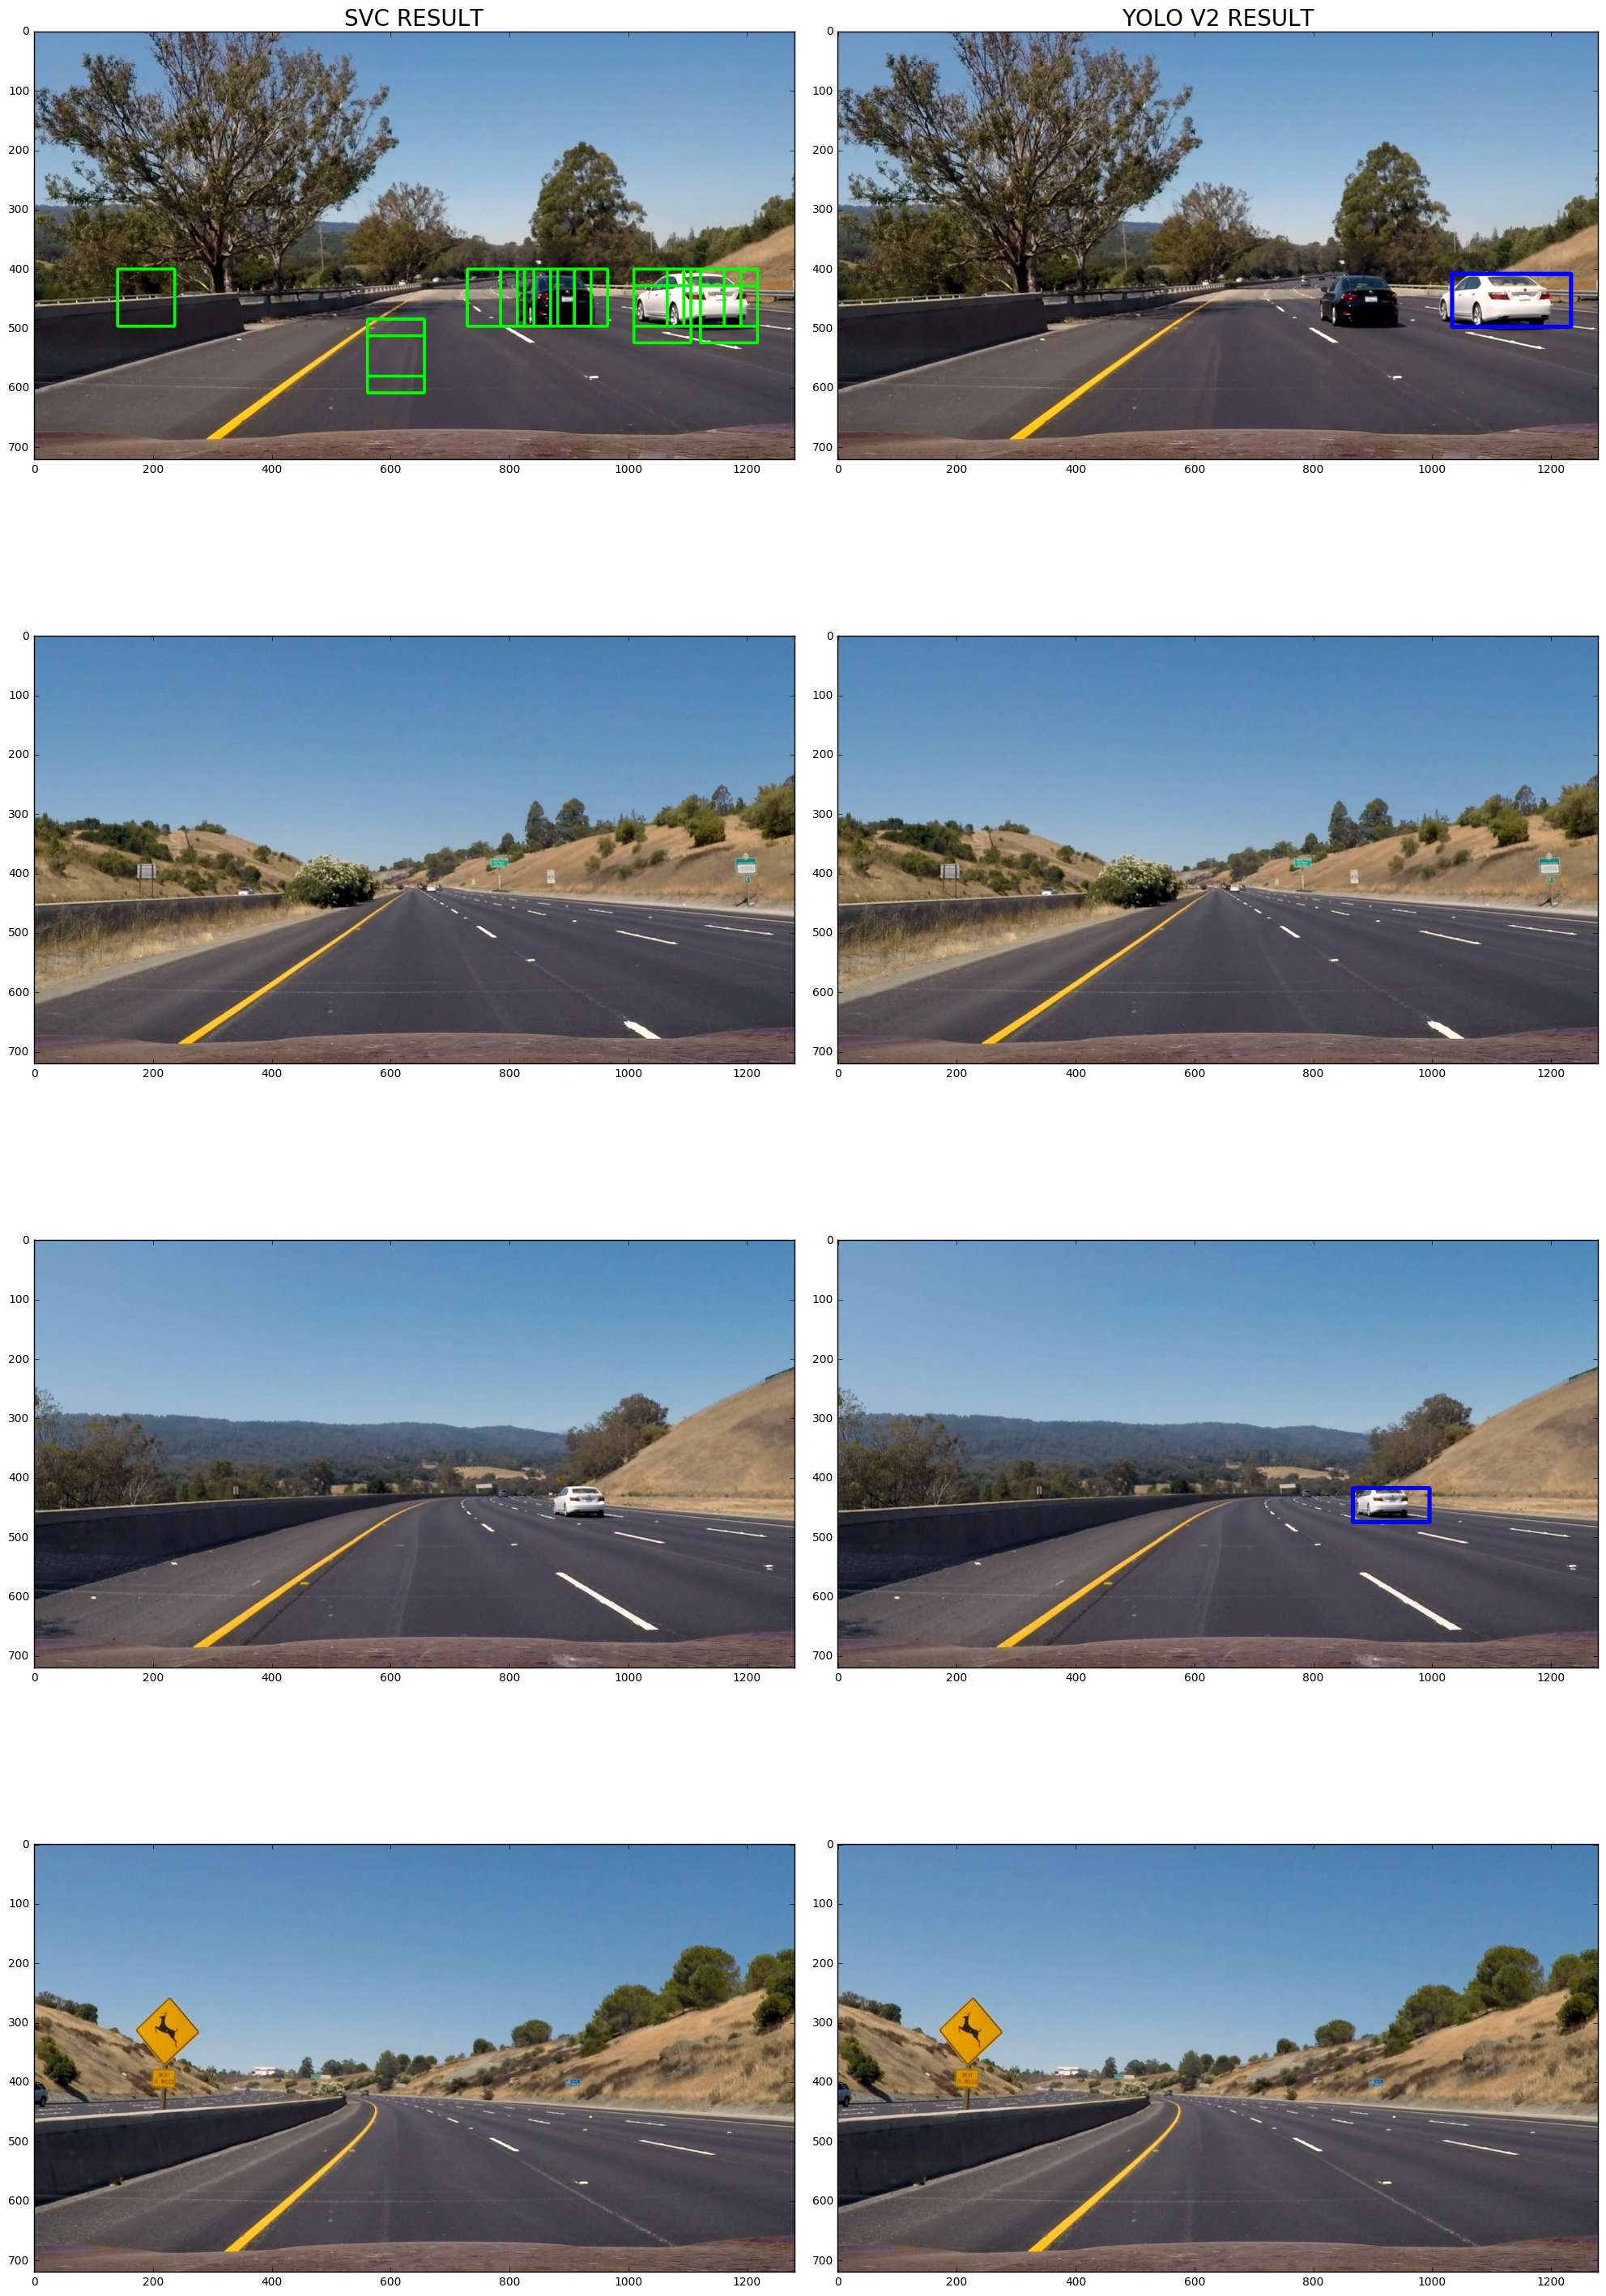

In [18]:
size = len(svc_results)
fg, a = plt.subplots(size, 2, figsize =(20,30))
fg.tight_layout()
a[0, 0].set_title("SVC RESULT", fontsize=20)
a[0, 1].set_title("YOLO V2 RESULT", fontsize=20)

for i in range(size):
    a[i, 0].imshow(svc_results[i])
    a[i, 1].imshow(yolo_results[i])

## Tweak 2: Subsampling HOG entire image and add Heatmap

In [74]:
# Method definitions
from utils import get_hog_features, bin_spatial, color_hist, convert_color
    
def find_cars(img, ystart, ystop, scale, svc, dec_thresh = 0.75, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=32, hist_bins=32):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    # Make a heat map of zero
    heatmap = np.zeros_like(img[:, : ,0])
    
    img_to_search = img[ystart:ystop, :, :]
    ctrans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (ctrans_to_search.shape[1] // pix_per_cell) - 1
    nyblocks = (ctrans_to_search.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ctrans_to_search,ch=0, feature_vec=False)
    hog2 = get_hog_features(ctrans_to_search,ch=1, feature_vec=False)
    hog3 = get_hog_features(ctrans_to_search,ch=2, feature_vec=False)

    img_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_to_search[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size, spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            # Pedict using your classifier
            dec = svc.decision_function(test_features)
            prediction = int(dec > dec_thresh)

            # If positive (prediction == 1) then save the window
            if prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+ystart+win_draw)))
    return heatmap, img_boxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of boxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return threshold-ed map
    return heatmap

from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Round 2: Improved SVC vs YOLO V2

#### Winner: SVC

In [75]:
dec_thresh = 0.95
ystart = 400
ystop = 656
scale = 1.5

yolo_avg_time = []
yolo_results = []
svc_results = []
svc_avg_time = []
heatmap_results = []

for img in glob.glob('./test_images/*.jpg'):
    # Open new image
    frame = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    svc_img = np.copy(frame)
    yolo_img = np.copy(frame)
    
    # SVC CLASSIFIER
    start = time.time()
    heatmap, windows = find_cars(frame, ystart, ystop, scale, svc, dec_thresh = 0.99)
    heatmap[heatmap <= 3.0] = 0
    labels = label(heatmap)
    svc_img = draw_labeled_bboxes(svc_img, labels)
    svc_avg_time.append(time.time() - start)
    
    # YOLOV2 CLASSIFIER
    start = time.time()
    yolo_windows = yolo.predict(frame)
    yolo_avg_time.append(time.time()-start)
    # Draw YOLO boxes
    yolo_img = draw_boxes(yolo_img, yolo_windows)
    # Process heatmap to filterout false positive

    heatmap = np.clip(heatmap, 0, 255)
    print("SVC found : {} results / Max Heatmap: {} || YOLO-V2 found: {} results".format(len(labels), np.max(heatmap),len(yolo_windows)))
    # Update result
    yolo_results.append(yolo_img)   
    svc_results.append(svc_img)
    heatmap_results.append(heatmap)
    
print("SVC Average processing time per img, {} seconds ".format(np.round(np.mean(svc_avg_time),4)))
print("YOLO Average processing time per img, {} seconds ".format(np.round(np.mean(yolo_avg_time),4)))

SVC found : 2 results / Max Heatmap: 6.0 || YOLO-V2 found: 1 results
SVC found : 2 results / Max Heatmap: 0.0 || YOLO-V2 found: 0 results
SVC found : 2 results / Max Heatmap: 0.0 || YOLO-V2 found: 1 results
SVC found : 2 results / Max Heatmap: 4.0 || YOLO-V2 found: 0 results
SVC found : 2 results / Max Heatmap: 4.0 || YOLO-V2 found: 1 results
SVC found : 2 results / Max Heatmap: 7.0 || YOLO-V2 found: 1 results
SVC found : 2 results / Max Heatmap: 6.0 || YOLO-V2 found: 2 results
SVC found : 2 results / Max Heatmap: 6.0 || YOLO-V2 found: 1 results
SVC Average processing time per img, 0.4038 seconds 
YOLO Average processing time per img, 0.5208 seconds 


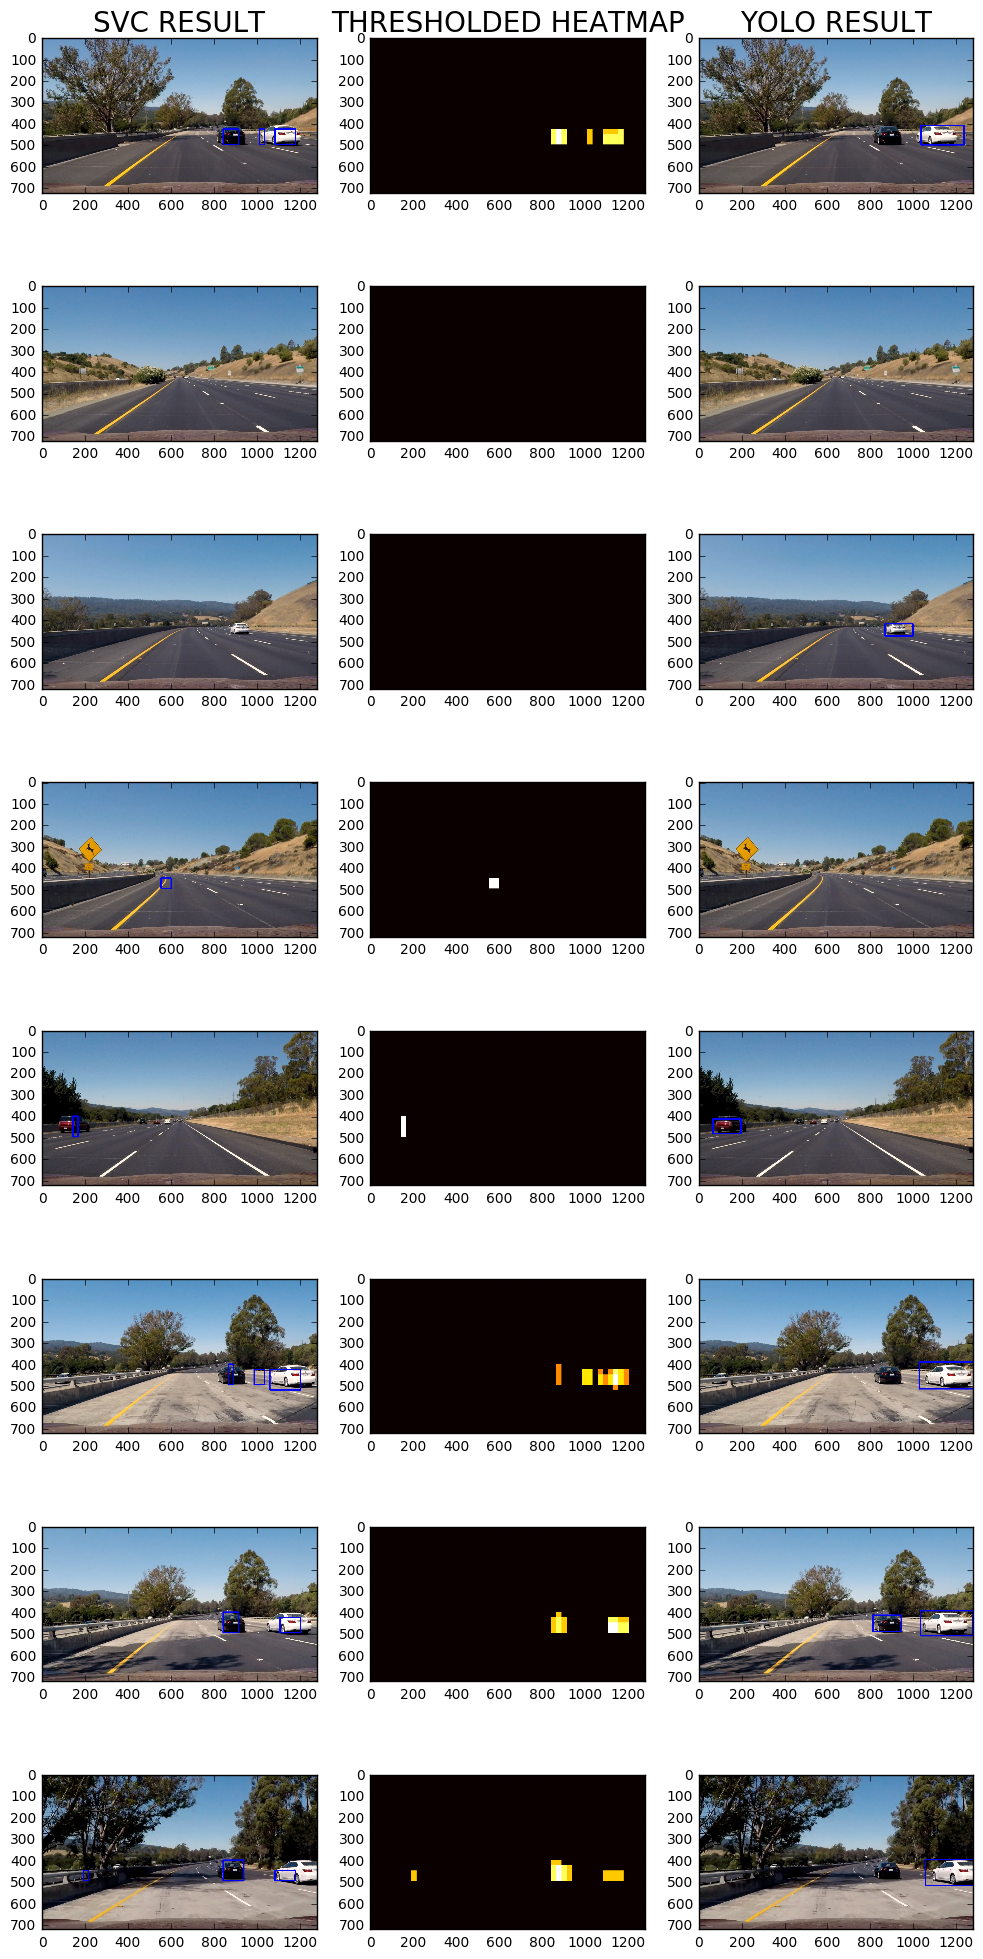

In [21]:
size = len(svc_results)
fg, a = plt.subplots(size, 3, figsize =(10,20))
fg.tight_layout()
a[0, 0].set_title("SVC RESULT", fontsize=20)
a[0, 1].set_title("THRESHOLDED HEATMAP", fontsize=20)
a[0, 2].set_title("YOLO RESULT", fontsize=20)

for i in range(size):
    a[i, 0].imshow(svc_results[i])
    a[i, 1].imshow(heatmap_results[i], cmap='hot')
    a[i, 2].imshow(yolo_results[i])

Testing for Vehicle Tracking using heatmap

(8, 720, 1280)
(13824, 2)


IndexError: index 840 is out of bounds for axis 0 with size 720

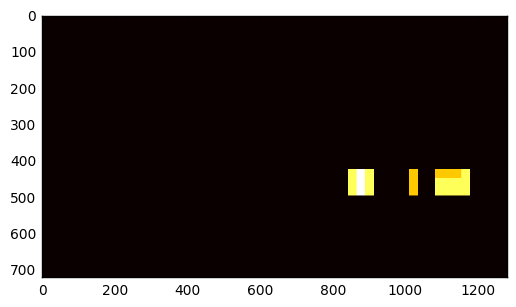

In [107]:
print(np.shape(heatmap_results))
example = heatmap_results[0]
plt.imshow(example, cmap='hot')

# Fastest way to iterate through image
x, y= (example > 3.0).nonzero()
val = np.dstack((y, x))[0].tolist()
print(np.shape(val))
example[val] = 255
for p in val:
    print("X: {}, Y: {}".format(p[0], p[1]))

### VEHICLE TRACKER PIPELINE

It observes the changes of heatmap over several previous frames `looking_back_frames` to determine where to add the car bounding boxes.

In [301]:
class Vehicle(object):
    # The minimum distance be considered two separate two object
    threshold = 10
    def __init__(self, x, y):
        # Bounding Box
        self.minx = x
        self.miny = y
        self.maxx = x
        self.maxy = y
        # Collection of pixels in that bounding box
        self.points = []
        self.points.append((x, y))
        self.id = 1
        
    def show(self):
        return (self.minx, self.miny), (self.maxx, self.maxy)

    def get_shape(self):
        return 0
        # Bounding box or countours 
        
    def get_center(self):
        # Get The edge of bounding box that closest to (x,y)
        cx = (self.minx + self.maxx)/2
        cy = (self.miny + self.maxy)/2
        
        return (cx, cy)
    
    def region(self):
        return self.points
    
    def add(self, x, y):
        # Add a new pixel into current Vehicle
        self.points.append((x, y))
        
        # Update the bounding box
        self.minx = min(self.minx, x)
        self.miny = min(self.miny, y)
        self.maxx = max(self.maxx, x)
        self.maxy = max(self.maxy, y)

    def isNear(self, x, y):
        # Determine if a new pixel (x, y) is belong to current object
        
        # Get The edge of bounding box that closest to (x,y)
        cx = (self.minx + self.maxx)/2
        cy = (self.miny + self.maxy)/2
        
        if cx == x and cy == y:
            return True
        
        # Distance(edge, pixel)
        dist = self.distSqt(cx, cy, x, y)

        # If distance is under a cetrain threshold. we can determine this pixel belongs to the current object
        # If blob is too small, update this
        if dist < 120:
            return True
        else:
            return False

    def distSqt(self, x1, y1, x2, y2):
        # Calculate Distance between two pixels
        delta_x = x1-x2
        delta_y = y1-y2
        dist = np.sqrt(delta_x**2 + delta_y**2)
        return dist

    def size(self):
        # print("Max X {} Min X {} // Max Y {} Min Y {}".format(self.maxx,self.minx, self.maxy, self.miny))
        return abs(self.maxx - self.minx)*abs(self.maxy - self.miny)



In [302]:
class VehicleTracker(object):
    
    def __init__(self, looking_back_frames=10):
        #  List of previous heat_maps
        self.heat_maps = []
        # How far to look back
        self.smooth_factor = looking_back_frames
        #  Tracked Vehicles
        self.tracked_vehicles = []

    def update(self, new_heat_map, threshold=10):
        
        # If we are just started to recording, keep summing
        self.tracked_vehicles = []
        if len(self.heat_maps) < self.smooth_factor:
            if len(self.heat_maps) > 2:
                # Check False Positive. 
                new_heat_map[(new_heat_map -  self.heat_maps[-1]) < 0] = 0
                
            self.heat_maps.append(new_heat_map)
            updated_map = np.sum(self.heat_maps, axis=0)
            
            # Remove objects that are not cars - low threshold
            updated_map[updated_map <= (threshold*(len(self.heat_maps)*1.5/self.smooth_factor))] = 0
        else:
            
            # Check False Positive. Look at previous frame and compare
            new_heat_map[(new_heat_map - self.heat_maps[-1]) < 0] = 0
              
            # Add new map to current heatmap
            self.heat_maps.append(new_heat_map)
            updated_map = np.sum(self.heat_maps, axis=0)
            
            # Remove the earliest heat map
            earliest_map = self.heat_maps.pop(0)
            updated_map -= earliest_map

            # Remove objects that are not cars - low threshold
            updated_map[updated_map <= threshold] = 0

        # list of all detected cars
        cars = self.find_vehicles(updated_map)
        
        # Compare to previous frame and remove or add more cars
        # cars = self.track_vehicles(cars)
        
        # Check if car is too small
        cars = [i for i in cars if i.size() > 2300]
        
        regions = [i.region() for i in cars]
        # Get boxes from car
        cars = [(i.show()) for i in cars]
        # print(len(cars))

        return regions, cars, updated_map
    
    def find_vehicles(self, updated_heatmap, threshold=3.):
        
        # Find pixels with value greater than threshold
        x, y = (updated_heatmap > threshold).nonzero()
        hot_pixels = np.dstack((y, x))[0].tolist() #
        detected_cars = []
        for pixel in hot_pixels:
            if len(detected_cars) is 0:         # Case 1: Empty list
                car = Vehicle(pixel[0],pixel[1])
                detected_cars.append(car)    
            else:                               # Case 2: Not empty
                found = False
                for vehicle in detected_cars:
                    if vehicle.isNear(pixel[0], pixel[1]) is True:
                        vehicle.add(pixel[0], pixel[1])
                        found = True
                        break               
                if found is False:
                    detected_cars.append(Vehicle(pixel[0], pixel[1]))             
        return detected_cars
    
    def track_vehicles(self, cars):
        '''
        Tracking car.. there are 4 scenarios (I hope)
        Case 1: No car
        Case 2: More car coming
        Case 3: Car is moving out of frame
        Case 4: Suddenly disappear
        '''
        if len(self.cars) is 0:
            # Is there a car in previous frame?
            return None
        
#         if len(self.tracked_vehicles) is 0:
#             self.tracked_vehicles = cars
#             return self.tracked_vehicles
        
#         if len(cars) == len(self.tracked_vehicles):
#              # Stablize bounding box here

#         # More cars detected            
#         if len(cars) > len(self.tracked_vehicles):
            
#         # Car disappear
#         if len(cars) < len(self.tracked_vehicles)
        
#         return cars

In [338]:
# Parameter
ystart = 400
ystop = 656
scales = 1.45
# Vehicle Tracker
car_tracker = VehicleTracker(looking_back_frames=15)

def process_image(frame):
    global svc
    global car_tracker
    global ystar, ystop, scale

    svc_img = np.copy(frame)
    
    heatmap, windows = find_cars(frame, ystart, ystop, scale, svc, dec_thresh=0.99)
    points, cars, heatmap = car_tracker.update(heatmap, threshold=33)
    # Draw car boxes
    for p1, p2 in itertools.chain(cars):
        cv2.rectangle(svc_img, p1, p2, (255, 255, 255), 4)
    
    offset = 50
    for p in points:
        print(p)
        p = .astype(np.uint32)
        cv2.fillPoly(svc_img, p, color=[255, 255, 255])
    # Create an heat image
    img = 255*heatmap/np.max(heatmap)
    img = np.dstack((img, heatmap, heatmap)).astype(np.uint8)

    svc_img = cv2.addWeighted(svc_img, 0.6, img, 1.0, 0.0)
    return svc_img

In [339]:
from moviepy.editor import VideoFileClip

output = 'output.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(37,37.3)
clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
clip.write_videofile(output, audio=False)

[(1008, 412), (1009, 412), (1010, 412), (1011, 412), (1012, 412), (1013, 412), (1014, 412), (1015, 412), (1016, 412), (1017, 412), (1018, 412), (1019, 412), (1020, 412), (1021, 412), (1022, 412), (1023, 412), (1024, 412), (1025, 412), (1026, 412), (1027, 412), (1028, 412), (1029, 412), (1030, 412), (1031, 412), (1032, 412), (1033, 412), (1034, 412), (1035, 412), (1036, 412), (1037, 412), (1038, 412), (1039, 412), (1040, 412), (1041, 412), (1042, 412), (1043, 412), (1044, 412), (1045, 412), (1046, 412), (1047, 412), (1048, 412), (1049, 412), (1050, 412), (1051, 412), (1052, 412), (1053, 412), (1054, 412), (1055, 412), (1056, 412), (1057, 412), (1058, 412), (1059, 412), (1060, 412), (1061, 412), (1062, 412), (1063, 412), (1064, 412), (1065, 412), (1066, 412), (1067, 412), (1068, 412), (1069, 412), (1070, 412), (1071, 412), (1072, 412), (1073, 412), (1074, 412), (1075, 412), (1076, 412), (1077, 412), (1078, 412), (1079, 412), (1008, 413), (1009, 413), (1010, 413), (1011, 413), (1012, 413)

TypeError: pts data type = 6 is not supported